In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

A brief overview of VQE
=======================

::: {.meta}
:property=\"og:description\": Find the ground state of a Hamiltonian
using the variational quantum eigensolver algorithm.
:property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//pes_h2.png>
:::

::: {.related}
tutorial\_quantum\_chemistry Building molecular Hamiltonians
vqe\_parallel VQE with parallel QPUs with Rigetti tutorial\_vqe\_qng
Accelerating VQE with quantum natural gradient
tutorial\_vqe\_spin\_sectors VQE in different spin sectors tutorial\_vqt
Variational quantum thermalizer
:::

*Author: Alain Delgado --- Posted: 08 February 2020. Last updated: 29
August 2023.*

The Variational Quantum Eigensolver (VQE) is a flagship algorithm for
quantum chemistry using near-term quantum computers. It is an
application of the [Ritz variational
principle](https://en.wikipedia.org/wiki/Ritz_method), where a quantum
computer is trained to prepare the ground state of a given molecule.

The inputs to the VQE algorithm are a molecular Hamiltonian and a
parametrized circuit preparing the quantum state of the molecule. Within
VQE, the cost function is defined as the expectation value of the
Hamiltonian computed in the trial state. The ground state of the target
Hamiltonian is obtained by performing an iterative minimization of the
cost function. The optimization is carried out by a classical optimizer
which leverages a quantum computer to evaluate the cost function and
calculate its gradient at each optimization step.

In this tutorial you will learn how to implement the VQE algorithm in a
few lines of code. As an illustrative example, we use it to find the
ground state of the hydrogen molecule, $\mathrm{H}_2$. First, we build
the molecular Hamiltonian using a minimal basis set approximation. Next,
we design the quantum circuit preparing the trial state of the molecule,
and the cost function to evaluate the expectation value of the
Hamiltonian. Finally, we select a classical optimizer, initialize the
circuit parameters, and run the VQE algorithm using a PennyLane
simulator.

Let\'s get started!

Building the electronic Hamiltonian
-----------------------------------

The first step is to specify the molecule we want to simulate. This is
done by providing a list with the symbols of the constituent atoms and a
one-dimensional array with the corresponding nuclear coordinates in
[atomic units](https://en.wikipedia.org/wiki/Hartree_atomic_units).


In [2]:
from jax import numpy as np
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

The molecular structure can also be imported from an external file using
the `~.pennylane.qchem.read_structure`{.interpreted-text role="func"}
function.

Now, we can build the electronic Hamiltonian of the hydrogen molecule
using the `~.pennylane.qchem.molecular_hamiltonian`{.interpreted-text
role="func"} function.


In [3]:
import pennylane as qml
import pickle

with open('qubits_acai_4.pkl', 'rb') as file:
    qubits = pickle.load(file)
    
with open('H_acai_4.pkl', 'rb') as fp:
    H = pickle.load(fp) 
print("Number of qubits = ", qubits)

Number of qubits =  8


The outputs of the function are the Hamiltonian, represented as a linear
combination of Pauli operators, and the number of qubits required for
the quantum simulations. For this example, we use a [minimal basis
set](https://en.wikipedia.org/wiki/STO-nG_basis_sets) to represent the
[molecular orbitals](https://en.wikipedia.org/wiki/Molecular_orbital).
In this approximation, we have four spin orbitals, which defines the
number of qubits. Furthermore, we use the Jordan-Wigner transformation
to perform the fermionic-to-qubit mapping of the Hamiltonian.

For a more comprehensive discussion on how to build the Hamiltonian of
more complicated molecules, see the tutorial
`tutorial_quantum_chemistry`{.interpreted-text role="doc"}.

::: {.note}
::: {.title}
Note
:::

A wide variety of molecular data, including Hamiltonians, is available
on the [PennyLane Datasets service](https://pennylane.ai/datasets). This
data can be downloaded using the
`~.pennylane.data.load`{.interpreted-text role="func"} function:

``` {.python}
dataset = qml.data.load('qchem', molname="H2")[0]
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
```

For more details, check out the [Quantum
Datasets](https://docs.pennylane.ai/en/stable/introduction/data.html)
documentation.
:::

Implementing the VQE algorithm
==============================

From here on, we can use PennyLane as usual, employing its entire stack
of algorithms and optimizers. We begin by defining the device, in this
case PennyLane's standard qubit simulator:


In [4]:
dev = qml.device("lightning.gpu", wires=qubits)

Next, we need to define the quantum circuit that prepares the trial
state of the molecule. We want to prepare states of the form,

$$\vert \Psi(\theta) \rangle = \cos(\theta/2)~|1100\rangle -\sin(\theta/2)~|0011\rangle,$$

where $\theta$ is the variational parameter to be optimized in order to
find the best approximation to the true ground state. In the
Jordan-Wigner encoding, the first term $|1100\rangle$ represents the
[Hartree-Fock (HF)
state](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) where
the two electrons in the molecule occupy the lowest-energy orbitals. The
second term $|0011\rangle$ encodes a double excitation of the HF state
where the two particles are excited from qubits 0, 1 to 2, 3.

The quantum circuit to prepare the trial state
$\vert \Psi(\theta) \rangle$ is schematically illustrated in the figure
below.

| 

![](/_static/demonstration_assets/variational_quantum_eigensolver/sketch_circuit.png){.align-center
width="50.0%"}

| 

In this figure, the gate $G^{(2)}$ corresponds to the
`~.pennylane.DoubleExcitation`{.interpreted-text role="class"}
operation, implemented in PennyLane as a [Givens
rotation](https://en.wikipedia.org/wiki/Givens_rotation), which couples
the four-qubit states $\vert 1100 \rangle$ and $\vert 0011 \rangle$. For
more details on how to use the excitation operations to build quantum
circuits for quantum chemistry applications see the tutorial
`tutorial_givens_rotations`{.interpreted-text role="doc"}.

Implementing the circuit above using PennyLane is straightforward.
First, we use the `hf_state`{.interpreted-text role="func"} function to
generate the vector representing the Hartree-Fock state.


In [5]:
electrons = 4
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 1 1 0 0 0 0]


The `hf` array is used by the `~.pennylane.BasisState`{.interpreted-text
role="class"} operation to initialize the qubit register. Then, we just
act with the `~.pennylane.DoubleExcitation`{.interpreted-text
role="class"} operation on the four qubits. The next step is to compute
the expectation value of the molecular Hamiltonian in the trial state
prepared by the circuit. We do this using the
`~.expval`{.interpreted-text role="func"} function. The decorator syntax
allows us to run the cost function as an executable QNode with the gate
parameter $\theta$:


In [6]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

We can now define our error function simply as the expected value
calculated above:


In [7]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

Now we proceed to minimize the cost function to find the ground state of
the $\mathrm{H}_2$ molecule. To start, we need to define the classical
optimizer. The library `optax` offers different
[optimizers](https://optax.readthedocs.io/en/latest/api.html). Here we
use a basic gradient-descent optimizer. We carry out the optimization
over a maximum of 100 steps aiming to reach a convergence tolerance of
$10^{-6}$ for the value of the cost function.


In [8]:
import optax

max_iterations = 100
conv_tol = 1e-6

opt = optax.sgd(learning_rate=0.000001)

We initialize the circuit parameter $\theta$ to zero, meaning that we
start from the Hartree-Fock state.


In [9]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)
    
    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/gleydson.jesus/.local/lib/python3.9/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step = 0,  Energy = -544.67547663 Ha

Final value of the ground-state energy = -544.67547663 Ha

Optimal value of the circuit parameter = 0.0000


In [10]:
energy

[Array(-544.67547663, dtype=float64), Array(-544.67547663, dtype=float64)]

Let\'s plot the values of the ground state energy of the molecule and
the gate parameter $\theta$ as a function of the optimization step.


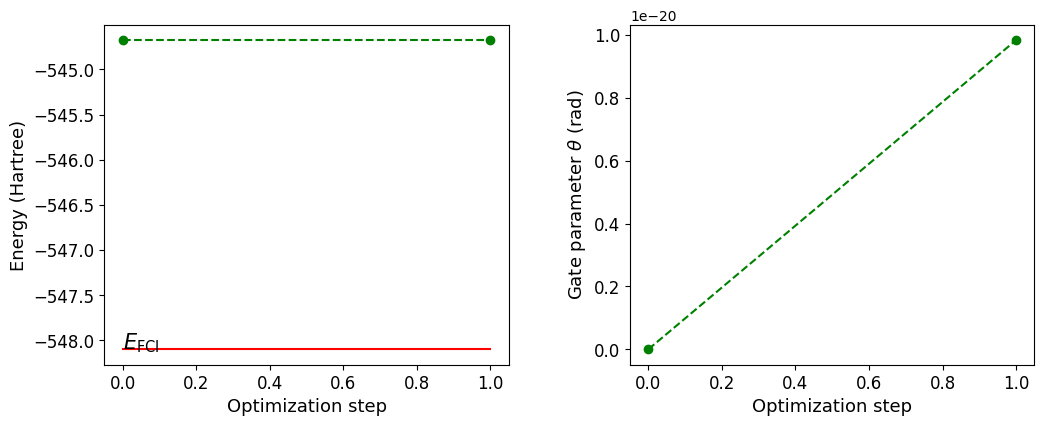

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -548.0992098097419

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
#ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -548.0992098097419, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In this case, the VQE algorithm converges after thirteen iterations. The
optimal value of the circuit parameter $\theta^* = 0.208$ defines the
state

$$\vert \Psi(\theta^*) \rangle = 0.994~\vert 1100 \rangle - 0.104~\vert 0011 \rangle,$$

which is precisely the ground state of the $\mathrm{H}_2$ molecule in a
minimal basis set approximation.

Conclusion
==========

In this tutorial, we have implemented the VQE algorithm to find the
ground state of the hydrogen molecule. We used a simple circuit to
prepare quantum states of the molecule beyond the Hartree-Fock
approximation. The ground-state energy was obtained by minimizing a cost
function defined as the expectation value of the molecular Hamiltonian
in the trial state.

The VQE algorithm can be used to simulate other chemical phenomena. In
the tutorial `tutorial_vqe_bond_dissociation`{.interpreted-text
role="doc"}, we use VQE to explore the potential energy surface of
molecules to simulate chemical reactions. Another interesting
application is to probe the lowest-lying states of molecules in specific
sectors of the Hilbert space. For example, see the tutorial
`tutorial_vqe_spin_sectors`{.interpreted-text role="doc"}. Furthermore,
the algorithm presented here can be generalized to find the equilibrium
geometry of a molecule as it is demonstrated in the tutorial
`tutorial_mol_geo_opt`{.interpreted-text role="doc"}.

References {#vqe_references}
==========

About the author
================
